# Reddit Clustering

For this project, we set to explore the topography of reddit. We wanted to see what subreddits are commonly used between users, if there are communities of users that act as links between subreddits, and if there are subreddits isolated from the main users' network of Reddit.

## Research Question

We are interested in clustering subreddits, by using comment and submission data to discern connections between subreddits and the users who are active in them. We are hoping to see similar userbases in subreddits we did not expect, along with disconnects in userbases between subreddits that appear intuitively similar. We want to use a Clustering algorithm to connect subreddits in space, and then calculate the distance between subreddits.We are interested in clustering subreddits, by using comment and submission data obtained from PRAW to discern connections between subreddits and the users who are active in them. We are hoping to see similar userbases in subreddits we did not expect, along with disconnections in userbases between subreddits that appear intuitively similar. We want to use a Clustering algorithm to connect subreddits in space, and then calculate the distance between subreddits. 

For the former part of research, we mainly focused on obtaining data set including reddit user, their comments and submissions for subreddits, cleaning out unnecessary features and pre-processing data for further exploration. Simple visualization of reddit posts distribution, relations between user posts number and posted subreddit number was displayed, which none of them has suggested significant results so far. For over 22,000 subreddits, there is a large portion with few data included, and handling this majority is believed to affect the following data analysis significantly. Multi-dimensional vectors implemented with array structure are also the major sources to perform data exploration and clustering on.

For the latter part, the main purpose will be completing data pre-processing,  figuring out correct application of Clustering Algorithm(method to choose, cluster number etc.) and displaying final visualization. The statistical analysis should also suggest some insights into the correlation among different subreddits and their active user community.

Several questions are expected to be answered while we proceed:

- How should we filter out the large amount of subreddits with few comments by simply removing the data or considering imputation methods? How should we determine a proper threshold for unpopular subreddits?

- K-means Clustering Algorithm seems to work for current data, but instead of presuming the number of classification arbitrarily, is there any statistical domain knowledge or library function we can refer to for more reliable output?

- The visualization in 2D space apparently fails to display more original properties for our multidimensional vectors. We need to implement proper functions to display more comprehensive data visualization, perhaps by using dimensionality reduction approach.


## Data Sources

All of our data is coming from reddit. Reddit submission and comment data is publicly accessible, and reddit has a nice API structure. We are using the package PRAW (python reddit api wrapper), which makes the reddit api calls easier to use and python importable. We are attempting to build subreddit comment vectors for a large number of reddit users. We would like to create nested dictionaries, the first level key being a reddit user, the second level keys being a subreddit name, and the values being how many time that specific user posted to a specific subreddit. 

Another important note is there are two kinds of ways to post to reddit, and the api distinguishes them. There are submissions and comments. Submissions are posts including an image, a video, or a question, and comments are replies and follow-ups to posts. Both kinds of posts on reddit are useful for the clustering we want to do, so we must do both.

We split our data scripts into different pieces, below is the documentation for each script, followed by the code. 

Also to gather any data from Reddit we must log on to the system with a developer id and create a reddit instance in our code. This happens once below.

In [1]:
import praw
import pandas as pd
import sys
import numpy as np
from scipy.spatial import distance

reddit = praw.Reddit(client_id='tc_fFbWZrkDSRw',
                     client_secret='fTq7nFVzdkCHFZY7jWQvHmkLpwk',
                     user_agent='lhimelman')

# userNameScraper.py:
  *A Scraper that gets just usernames, does it very quickly. 6000 usernames can be collected in a few minutes*

  EX: 
      
      
      python3 userNameScraper.py *saveFilename* *ListofSubreddit* *numberofpoststolookat*
      
      python3 userNameScraper.py data.txt funny,pics,todayilearned 100

In [2]:
def scrapeUsers(reddit, subredditList, postNum):
    subnum = 0
    for subredditname in subredditList:
        users = []
        posts = reddit.subreddit(subredditname).hot(limit=postNum)
        pc = 0
        for submission in posts:
            all_comments = submission.comments.list()
            for c in all_comments:
                try:
                    name = c.author.name
                    if name not in users:
                        users.append(name)
                except:
                    pass
            pc = pc + 1
            print( pc, "post")
        subnum = subnum + 1
        print( subnum, "subreddit")
    return users

##An example call scraping one post from r/funny
users = scrapeUsers(reddit,['politics'],1)
users

1 post
1 subreddit


['Hrekires',
 'Thoramel',
 'dallasmorningnews',
 'Sip_py',
 'TransQuantinentalAce',
 'GotOutOfCowtown',
 'darkseadrake',
 'jimbozak',
 'becauseineedone3',
 'neverliveindoubt',
 'bivalve_attack',
 'TrumpImpeachedAugust',
 'DistillateMedia',
 'wjbc',
 'MaimedJester',
 'HorsecockBillionaire',
 'Communist99',
 'PrincessSandySparkle',
 'Burning_Lovers',
 'Choco316',
 'esteban1386',
 'nuncio-tc',
 'Schkateboarda',
 'all2neat',
 'IMAVINCEMCMAHONGUY',
 'erratically_sporadic',
 'dead_pirate_robertz',
 'not-working-at-work',
 'garybusey42069',
 '10iss',
 'Vernacularry',
 'wisdom_and_frivolity',
 'halebara01',
 'ThrowAway_Phone',
 'Tsalnor',
 'ericolinn',
 'HippyHunter7',
 'KellyJoyCuntBunny',
 'frivolous_name',
 'JacenGraff',
 'Roidciraptor',
 'TempAcct20005']

# ScrapeFreqfromUser.py:
  *A scraper that gets frequencies of comments from a list of users*

  EX: 
    
        python3 ScrapeFreqfromUser.py *savefielName* *userlistfilename*
     
    
        python3 ScrapeFreqfromUser.py freq.txt users.txt

In [3]:
def scrapeSubreddit(reddit, users):
    commentFreq = {}
    headers = []
    usernum = 1
    for user in users:
        userCFreq = {}
        for comment in reddit.redditor(user).comments.new(limit=None):
            sub = comment.subreddit
            if sub not in userCFreq:
                userCFreq[sub] = 1
            else:
                userCFreq[sub] += 1
            if sub not in headers:
                headers.append(sub)
        commentFreq[user] = userCFreq
        usernum = usernum + 1
        print(usernum, "out of", len(users))
    return commentFreq,headers

##An example call scraping the users gotten above
cfreq,headers = scrapeSubreddit(reddit, users[0:3])
df = pd.DataFrame.from_dict(data=cfreq, orient='index').fillna(0)
df

2 out of 3
3 out of 3
4 out of 3


,wow,AskReddit,askgaybros,politics,newjersey,technology,news,worldnews,conspiracy,personalfinance,...,IAmA,houston,TropicalWeather,nfl,baseball,comicbooks,doctorwho,theticket,MadeMeSmile,u_kn0thing
Hrekires,10.0,377.0,40.0,428,38.0,14.0,45,23.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thoramel,0.0,16.0,0.0,35,0.0,0.0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dallasmorningnews,0.0,0.0,0.0,423,0.0,0.0,2,1.0,0.0,0.0,...,87.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0


# ScrapeSubFreqfromUser.py:
  *A scraper that gets frequencies of submissions from a list of users*

  EX: 
    
        python3 ScrapeSubFreqfromUser.py *savefielName* *userlistfilename*
     
    
        python3 ScrapeSubFreqfromUser.py freq.txt users.txt

In [4]:
def scrapeSubreddit(reddit, users):
    subFreq = {}
    headers = []
    usernum = 1
    for user in users:
        userCFreq = {}
        for submission in reddit.redditor(user).submissions.new(limit=None):
            sub = submission.subreddit
            if sub not in userCFreq:
                userCFreq[sub] = 1
            else:
                userCFreq[sub] += 1
            if sub not in headers:
                headers.append(sub)
        subFreq[user] = userCFreq
        usernum = usernum + 1
        print(usernum, "out of", len(users))
    return subFreq,headers

subfreq,headers = scrapeSubreddit(reddit, users[0:3])
df = pd.DataFrame.from_dict(data=subfreq, orient='index').fillna(0)
df

2 out of 3
3 out of 3
4 out of 3


,news,politics,worldnews,subaru,AskReddit,iamverybadass,RealEstate,DataHoarder,newjersey,CircleofTrust,...,Whataburger,thebachelor,AnimalsBeingBros,retrogaming,nfl,gaming,books,DCcomics,BravoRealHousewives,playstation
Hrekires,4.0,170.0,2.0,1.0,5.0,1.0,2.0,1.0,9.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thoramel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dallasmorningnews,11.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


At this point, we have two sparse matrices in which each column is a vector for an individual subreddit that contains frequencies of different users posting to or commenting on that subreddit.

***
The above calls are examples of running our scripts, but of course our actual data sets, (which we only want to pull down once), are much larger.
***

## Data Cleaning

The data came to us pretty clean. Reddit's api allows us to filter deleted comments and such. Our data cleaning and preprocessing included three different tasks. Below is the first 100 rows of our large table, and then a description of each task. 

In [5]:
bigdf = pd.read_csv('../data.csv',nrows=100)
bigdf

,Unnamed: 0,cocktails,AskReddit,videos,hearthstone,PUBATTLEGROUNDS,dontdeadopeninside,CompetitiveHS,funny,TWWPRDT,...,firefall,KUFIIOnline,atlantar4r,HeadBangToThis,Kochen,aachen,KnitRequest,petplay,Balls,peachfuzz
0,--abadox--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--arete--,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-COPBLOCK-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-Chakas-,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-DisobedientAvocado-,0.0,61.0,0.0,0.0,0.0,0.0,0.0,24.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-Enrique_Shockwave-,0.0,3.0,0.0,2.0,0.0,40.0,0.0,50.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-FuckYourGod,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-KyloRen,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-Mateo-,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-Meik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Task One:
    
    Create a method for removing very sparse vectors from our dataset. In looking through the data, we realized that there are some subreddits with really very few posts, that appears in our set of vectors without really doing anything. We decided to test clustering with the whole set and with smaller sets, so we made a way of thresholding how many posts a subreddit needs to be included.

In [6]:
Threshold = 10

def delSparse(df, threshold):
    for c in list(df)[1:]:
        if sum(list(df[c])) < Threshold:
            del df[c]
            
delSparse(bigdf,Threshold)
bigdf.shape

(100, 712)

# Task Two:
    Format data so it is in the form expected by the clustering algorithm. The following code takes the dataframe and changes it to a numpy array. The code also saves a list of headers for referencing specific nodes in a cluster later.
    
    

In [7]:
from numpy import array

def changetoVec(df):
    vectors = []
    for c in list(df)[1:]:
        vectors.append(list(df[c]))

    return array(vectors)

bigdfVec = changetoVec(bigdf)
print(bigdfVec)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Task Three:
    Remove Porn. What we discovered is that most porn subreddits fell under the category of incredibly sparse vectors, and so were removed, the ones that we decided not to include in our analysis for now. 

## Now we can try clustering:
    As it happens running unsupervised learning is not that complicated. We can run the clustering algorithm on our vectors fairly easy, but there are two problems. The first is we dont know what the optimal number of clusters our algorithm should produce is. We must find a way to choose a cluster number with the least error.

In [49]:
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt


##A function that clusters with a given K
def Cluster(vectors, Num_clusters):
    whitened = whiten(vectors)
    codebook, distortion = kmeans(whitened, Num_clusters)
    return codebook, distortion

##An example of the centroids returned by clustering
codebook, dist = Cluster(bigdfVec[1:1000],5)
whitened = whiten(bigdfVec[1:100])

## The list of centroids
codebook

#The estimated error of the clustering given that k value
##dist


array([[1.01035859e+01, 2.76409009e+00, 1.54165791e+01, 1.00852476e+01,
        1.17177974e+00, 4.50723208e+00, 1.99079147e+00, 4.75365852e+00,
        4.12391681e-01, 2.01932023e+01, 1.37309955e+00, 1.19231474e-01,
        4.89640941e+00, 1.09269517e-01, 9.49323976e+00, 2.59162044e+01,
        1.39639159e+00, 8.32919790e+00, 5.18692065e+00, 3.35412679e+00,
        9.23726959e-01, 2.03193710e+01, 2.65150155e+00, 1.05703844e+01,
        2.34317358e+00, 2.42189041e+00, 1.71071173e+00, 2.42688598e+00,
        1.00560781e+00, 1.66937808e+01, 7.03526082e-01, 6.24705544e+00,
        1.93766370e+01, 6.92448019e+00, 4.58306467e-01, 6.22470245e+00,
        7.42947015e+00, 2.82671177e+00, 2.29251295e+00, 2.10169318e-01,
        1.05801813e+00, 4.33147739e-01, 2.75721788e+00, 7.12806976e+00,
        9.39603271e+00, 5.35799529e+00, 2.02590432e+00, 1.11527105e+01,
        7.61979428e+00, 9.49302125e+00, 2.19933380e+01, 1.26398137e+00,
        3.71276911e+00, 1.19315093e+01, 6.42432925e-01, 2.015654

The Distortion value returned from the k-means algorithm is the value that represents the error of that many clusters. So our first thought is to simply minimize that error. Below we create a list of all possible distortions for our data.

Text(0.5,0,'# of Clusters')

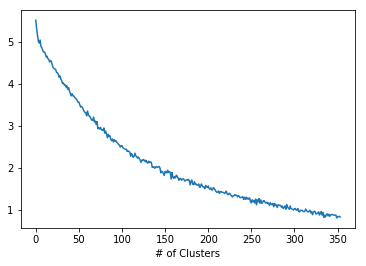

In [46]:
#####WARNING, THIS TAKES A WHILE

##Get all distortions
distortions = []
for i in range(1,int(len(list(bigdfVec))/2)):
    cb, dist = Cluster(bigdfVec, i)
    distortions.append(dist)
plt.plot(distortions)
plt.xlabel("# of Clusters")

It is easy to see the problem with just choosing the minimum here. The minimum will always be the same number of clusters as datapoints! This number of clusters isn't useful however, as having the same number of clusters as datapoints, is 100% overfitting. A common technique to combat this used alongside k-means, is finding when the maximum jump appears of inverted distortiong values. Below is the code to find the number of clusters when that point occurs. 

In [10]:
#Look for the maximum distortion jump. This should be our best k.

maxdistjump = 0
maxk = 0
for i in range(1, len(distortions)):
    if distortions[i] - distortions[i-1] > maxdistjump:
        maxdistjump = distortions[i] - distortions[i-1]
        maxk = i
        
print(maxk)
print(maxdistjump)

finalcb, finaldist = Cluster(bigdfVec, maxk)

161
0.1610071792563812


Now we have our theoretically best K value. Lets compute distances between each subreddit and cluster centers, then look at which subreddits are most in a specific cluster.

In [11]:
##compute distances between every subreddit and cluster centers for the best k we found

Clusterdistframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(finalcb)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(finalcb[i], v2))
    Clusterdistframe.loc[i] = dists
Clusterdistframe.head()

,cocktails,AskReddit,hearthstone,dontdeadopeninside,funny,TWWPRDT,vexillology,therewasanattempt,IntoTheBreach,news,...,blackcoin,Bergen,HighQualityReloads,EarlyPKA,saskatoon,collegeresults,lockn,WouldYouFuckMyWife,Schoolhouse,type2diabetes
0,51.380438,90.853529,17.108290,51.179220,261.398373,1003.676495,12.468918,29.661008,56.198008,168.553349,...,27.273489,17.431099,51.145315,10.716492,19.386676,10.716492,34.217586,67.110679,18.134486,24.307266
1,51.268915,91.043968,16.867175,51.220129,261.670088,1003.811827,12.103784,29.722861,57.389037,168.841982,...,27.027793,17.044107,51.014719,10.074800,19.039475,10.074800,34.022075,67.011205,18.041663,24.031263
2,49.771733,89.421254,22.501484,53.286465,254.648106,1001.853369,19.161600,29.489406,58.571805,165.888842,...,30.859630,22.634416,52.940550,17.981011,24.172645,12.247015,37.139154,68.646316,23.394802,28.272191
3,59.292150,93.519786,34.477525,57.595360,262.138512,1003.690600,32.626682,41.232841,64.675202,169.707820,...,40.601729,34.763492,59.333805,31.929616,35.784080,31.929616,45.557660,73.542507,35.263301,38.671700
4,51.377188,90.719642,13.623515,51.106817,261.162735,1003.730098,12.577194,29.807730,57.423350,168.082934,...,27.249893,17.394157,51.132736,10.656298,19.353467,10.656298,34.198782,67.101093,18.052954,24.206786


Now we can get the 100 minimum and the 100 maximum subreddits for each cluster

In [12]:
mins = pd.DataFrame()
maxs = pd.DataFrame()
for index,row in Clusterdistframe.iterrows():
    mins[index] = list(Clusterdistframe.columns[row.argsort()][0:100])
    maxs[index] = list(Clusterdistframe.columns[row.argsort()][-99:])
    
mins=mins.transpose()
maxs=maxs.transpose()

In [13]:
mins

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,DIY,mildlyinfuriating,UNBGBBIIVCHIDCTIICBG,friendsafari,Anxiety,confession,mariokart,engrish,pitbulls,williamsburg,...,gatekeeping,TurboGrafx,BuyItForLife,AdventureBuilders,INEEEEDIT,carporn,glitch_art,DRZ400,megalinks,anime_irl
1,mildlyinfuriating,friendsafari,DIY,Anxiety,confession,mariokart,engrish,pitbulls,williamsburg,Cooking,...,carporn,ChoosingBeggars,INEEEEDIT,BuyItForLife,megalinks,ShadowTactics,anime_irl,glutenfree,DRZ400,holdmycosmo
2,collegeresults,Nexus6P,truetf2,facebookwins,TheWayWeWereOnVideo,DADI,MemeHunter,3DS,classiccars,Portland,...,IASIP,cyclocross,UNBGBBIIVCHIDCTIICBG,CollegeBasketball,ChoosingBeggars,darkestdungeon,NSFWFunny,eu4,tDCS,BuyItForLife
3,realfights,EscapefromTarkov,speedtest,OnceUponATime,Queens,Israel,GardenWild,glutenfree,boardgames,listentothis,...,cade,eu4,vidme,RimWorld,tasker,SugarPine7,CasualUK,worldbuilding,ketorecipes,PenmanshipPorn
4,mildlyinfuriating,forcedorgasms,friendsafari,DIY,confession,Anxiety,DRZ400,mariokart,engrish,pitbulls,...,gatekeeping,StreetFights,podcasts,facebookwins,BuyItForLife,glitch_art,ChoosingBeggars,carporn,ShadowTactics,megalinks
5,mildlyinfuriating,friendsafari,DIY,confession,mariokart,engrish,Anxiety,MsBreezy,pitbulls,parrots,...,megalinks,AdventureBuilders,BuyItForLife,anime_irl,INEEEEDIT,carporn,holdmycosmo,ShadowTactics,DRZ400,glutenfree
6,CombatFootage,starterpacks,williamsburg,mildlyinfuriating,friendsafari,DIY,confession,mariokart,Anxiety,engrish,...,Robocop,EverWing,INEEEEDIT,ChoosingBeggars,carporn,BuyItForLife,anime_irl,megalinks,ShadowTactics,glutenfree
7,tooktoomuch,Minecraft,Cooking,BuyItForLife,mturk,de,PcMasterRaceBuilds,TorontoAnarchy,engrish,mildlyinfuriating,...,AdventureBuilders,SteamController,forcedorgasms,facebookwins,ColbertRally,gatekeeping,TurboGrafx,megalinks,glitch_art,StreetFights
8,mildlyinfuriating,friendsafari,DIY,confession,mariokart,Anxiety,engrish,pitbulls,parrots,Cooking,...,iwanttoapologize,INEEEEDIT,carporn,BuyItForLife,anime_irl,megalinks,ShadowTactics,glutenfree,DRZ400,TheWayWeWereOnVideo
9,asklaw,Washington,williamsburg,BirdsBeingDicks,Robocop,iwanttoapologize,mildlyinfuriating,Anxiety,parrots,pitbulls,...,BuyItForLife,forcedorgasms,Edinburgh,eu4,tasker,CasualUK,nottheonion,worldbuilding,SugarPine7,redneckengineering


In [14]:
del maxs[2]
del maxs[3]
del maxs[4]
del maxs[5]
maxs

,0,1,6,7,8,9,10,11,12,13,...,89,90,91,92,93,94,95,96,97,98
0,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
1,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
2,TheFacebookDelusion,linux_devices,oddlysatisfying,Denmark,TheBullWins,NovaLauncher,CODModernWarfare,spaceporn,bodyperfection,sanfrancisco,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
3,motorcitykitties,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
4,TheFacebookDelusion,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
5,MarkMyWords,linux_devices,Denmark,TheBullWins,NovaLauncher,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
6,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
7,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
8,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
9,MarkMyWords,linux_devices,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,ChildrenFallingOver,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics


So there's a problem. By looking at this list we can see that there are unique clusters, but many of the clusters contain the same minimum subreddits, or they contain the same maximum subreddits. For example, there are many centroids very close to mildy_infuriating, which in and of itself is mildly infuriating. More importantly however, outliers appear to be super obvious, in that there are no cluster centers anywhere close to some subreddits, like Unity3D, and Denmark. Despite the fact that 297 clusters is mathematically the right number of clusters. It is harder to interpret on a human scale, so we also decided to guess a small number of clusters and look at the subreddits that appeared as minimums and maximums with less clusters.

In [15]:
##cluster
guesscb, guessdist = Cluster(bigdfVec, 10)

##Get distances
guessClusterdistframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(guesscb)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(guesscb[i], v2))
    guessClusterdistframe.loc[i] = dists

##Get mins and maxs
gmins = pd.DataFrame()
gmaxs = pd.DataFrame()
for index,row in guessClusterdistframe.iterrows():
    gmins[index] = list(guessClusterdistframe.columns[row.argsort()][0:100])
    gmaxs[index] = list(guessClusterdistframe.columns[row.argsort()][-99:])
    
gmins=gmins.transpose()
gmaxs=gmaxs.transpose()

In [29]:
gmins

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,youtube,humor,newjersey,Mustang,csgo,MapsWithoutNZ,tasker,BuyItForLife,teslamotors,Homebrewing,...,Diablo3Wizards,3DS,darkestdungeon,CrappyDesign,unpopularopinion,classiccars,BlackHairedGirls,vidme,prettyaltgirls,AdventureBuilders
1,ghostbusters,Portland,mturk,parrots,furry_irl,mildlyinfuriating,MMA,mariokart,corgibutts,confession,...,nspire,Gameboy,CrappyDesign,classiccars,CasualUK,netneutrality,StreetFights,Edinburgh,iwanttoapologize,forcedorgasms
2,mildlyinfuriating,friendsafari,Anxiety,confession,DIY,pitbulls,williamsburg,mariokart,Cooking,engrish,...,KotakuInAction,carporn,AdventureBuilders,facebookwins,TorontoAnarchy,glutenfree,iwanttoapologize,anime_irl,Edinburgh,megalinks
3,1500isplenty,BlackwakeGame,reallifedoodles,FiestaST,baconit,TNA,niceguys,trailerparkboys,LatinaCuties,Doom,...,CasualUK,Honolulu,cyclocross,UNBGBBIIVCHIDCTIICBG,tasker,darkestdungeon,RimWorld,eu4,cade,vidme
4,StardewValley,gunpolitics,bootroom,corgibutts,classiccars,CyclePDX,StreetFights,Washington,witcher,williamsburg,...,LegalAdviceUK,INEEEEDIT,TabooFX,OGame,stormtoken,TheoryOfReddit,subnautica,BadSocialScience,FilmIndustryLA,Honolulu
5,HaloOnline,technology,asmr,therewasanattempt,philosophy,synology,Rainbow6,keto,voiceover,whitepeoplegifs,...,ColumbusGaymers,HadToHurt,Mustang,BadSocialScience,CyclePDX,INEEEEDIT,dadjokes,HillaryForPrison,LivestreamFail,Zoomies
6,mildlyinfuriating,friendsafari,DIY,confession,Anxiety,mariokart,engrish,pitbulls,williamsburg,parrots,...,glitch_art,INEEEEDIT,BuyItForLife,carporn,anime_irl,DRZ400,glutenfree,ShadowTactics,megalinks,holdmycosmo
7,helpme,nsfwoutfits,EarlyPKA,TNA,vidme,ColbertRally,HitBoxPorn,mildlyinfuriating,friendsafari,DIY,...,glitch_art,StreetFights,AdventureBuilders,Robocop,iwanttoapologize,INEEEEDIT,ChoosingBeggars,carporn,BuyItForLife,anime_irl
8,dashcamgifs,Malazan,ReZeroHentai,shittyaskreddit,SkydTech,chess,RimWorld,nulsservice,HitBoxPorn,SteamController,...,eu4,vidme,cade,tasker,SugarPine7,worldbuilding,PenmanshipPorn,nottheonion,BadSocialScience,furry_irl
9,whitepeoplegifs,food,tipofmyjoystick,ANormalDayInRussia,AskReddit,keto,nba,WhereDidTheSiloGo,bicycling,FortNiteBR,...,Diablo3Wizards,AskNYC,photography,kotor,progmetal,corgibutts,Cinemagraphs,RealGirls,SOSgame,Lottery


One thing we would like to see is if these minimums are statistically significant, to do this lets take three example that seem close together. Youtube, humor, and csgo, and see if they are far away from the other clusters, not just close to the chosen cluster.

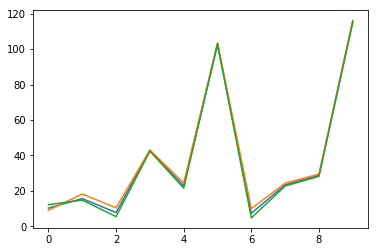

In [41]:
plt.plot(guessClusterdistframe['humor'])
plt.plot(guessClusterdistframe['youtube'])
plt.plot(guessClusterdistframe['parrots'])

The good news is these lines look similar, and the distance is generally much greater for other clusters. It is interesting that all these clusters ended up in 2 even though they are also very close to cluster 6.

In [17]:
del gmaxs[2]
del gmaxs[3]
del gmaxs[5]
gmaxs

,0,1,4,6,7,8,9,10,11,12,...,89,90,91,92,93,94,95,96,97,98
0,TheFacebookDelusion,MarkMyWords,AsheronsCall,oddlysatisfying,TheBullWins,NovaLauncher,Denmark,CODModernWarfare,bodyperfection,spaceporn,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
1,motorcitykitties,witbox,bicycling,linux_devices,oddlysatisfying,Denmark,AsheronsCall,NovaLauncher,TheBullWins,CODModernWarfare,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
2,MarkMyWords,linux_devices,AsheronsCall,NovaLauncher,Denmark,TheBullWins,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
3,TheFacebookDelusion,linux_devices,ForeverAlone,TheBullWins,SWlegion,Denmark,NovaLauncher,CODModernWarfare,fightsticks,bodyperfection,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
4,TheFacebookDelusion,linux_devices,ForeverAlone,oddlysatisfying,SWlegion,TheBullWins,NovaLauncher,Denmark,CODModernWarfare,bodyperfection,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
5,digitaltabletop,jailbreak,linux_devices,HITsWorthTurkingFor,zelda,tall,Naruto,SWlegion,TheFacebookDelusion,MarkMyWords,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
6,MarkMyWords,linux_devices,AsheronsCall,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,spaceporn,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
7,MarkMyWords,linux_devices,ForeverAlone,Breadit,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,CODModernWarfare,bodyperfection,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
8,TheFacebookDelusion,WouldYouFuckMyWife,ForeverAlone,SWlegion,Denmark,bicycling,NovaLauncher,TheBullWins,CODModernWarfare,PokemonGoDenver,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
9,digitaltabletop,NHLHUT,ramen,Utrecht,ForeverAlone,zelda,witbox,motorcitykitties,AsheronsCall,CODModernWarfare,...,Anticonsumption,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics


These results are a little more interesting to look at, in that there is a significant difference between the minimum subreddits that appear in each cluster. The maximums still arent that interesting, as those outlier subreddits are still really far away. This distance could indicate that those subreddits have pretty isolated userbases, which honestly makes sense. Politics is a subreddit that appears at a very high distance from most other subreddits. This implies that lots of users post on politics, and only politics. Which is certainly very possible, and in fact very likely.

The next thing we thought would be interesting is to not only plot subreddits to cluster centers, but subreddits to each other, to see total minimum distances and maximum distances between subreddits. 

In [44]:
from scipy.spatial import distance
##compute distances between every subreddit and put them in a massive table

distframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(bigdfVec)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(bigdfVec[i], v2))
    distframe.loc[i] = dists
distframe.index = list(bigdf)[1:]
distframe

,cocktails,AskReddit,hearthstone,dontdeadopeninside,funny,TWWPRDT,vexillology,therewasanattempt,IntoTheBreach,news,...,blackcoin,Bergen,HighQualityReloads,EarlyPKA,saskatoon,collegeresults,lockn,WouldYouFuckMyWife,Schoolhouse,type2diabetes
cocktails,0.000000,103.754518,53.944416,72.449983,256.003906,1003.533258,52.649786,49.749372,76.935038,175.806712,...,57.930993,54.000000,72.304910,52.220686,54.662601,52.220686,61.506097,84.356387,54.323107,56.595053
AskReddit,103.754518,0.000000,90.293964,102.752129,247.707489,984.601442,88.943802,90.055538,105.697682,153.502443,...,94.968416,92.622891,104.359954,91.596943,92.601296,91.596943,97.190535,110.648091,89.654894,92.097774
hearthstone,53.944416,90.293964,0.000000,52.392748,258.862898,1001.366566,20.493902,32.817678,59.321160,164.590401,...,31.811947,23.916521,53.702886,19.570386,25.377155,19.570386,37.934153,65.084560,24.637370,27.622455
dontdeadopeninside,72.449983,102.752129,52.392748,0.000000,258.671606,1000.382927,52.602281,58.275209,76.170861,168.745370,...,57.887823,53.953684,72.270326,52.172790,54.616847,52.172790,61.465437,84.326745,54.277067,56.550862
funny,256.003906,247.707489,258.862898,258.671606,0.000000,951.753645,259.395451,243.903670,258.416331,194.581602,...,263.058929,262.221281,266.593323,261.860650,261.923653,259.482177,263.869286,266.112758,260.704814,261.669639
TWWPRDT,1003.533258,984.601442,1001.366566,1000.382927,951.753645,0.000000,1002.793598,993.843046,1001.976048,963.374797,...,1003.844111,1003.754452,1002.127237,1003.830663,1003.915833,1003.422144,1003.085241,1005.264642,1003.471973,1002.897801
vexillology,52.649786,88.943802,20.493902,52.602281,259.395451,1002.793598,0.000000,28.896367,56.062465,166.210710,...,29.563491,20.832667,52.402290,15.652476,22.494444,15.652476,36.069378,68.073490,21.656408,25.000000
therewasanattempt,49.749372,90.055538,32.817678,58.275209,243.903670,993.843046,28.896367,0.000000,59.514704,158.911925,...,40.137264,34.219877,59.016947,31.336879,34.713110,30.692019,45.144213,72.367120,30.886890,36.249138
IntoTheBreach,76.935038,105.697682,59.321160,76.170861,258.416331,1001.976048,56.062465,59.514704,0.000000,172.849646,...,63.411355,59.841457,76.765878,58.240879,60.440053,58.240879,66.693328,88.209977,60.133186,61.806149
news,175.806712,153.502443,164.590401,168.745370,194.581602,963.374797,166.210710,158.911925,172.849646,0.000000,...,170.827398,169.593632,174.922840,169.136040,169.570045,169.136040,168.234955,172.956642,166.910155,169.266063


# plotting:

    These distance values are useful, but we wanted to be able and visualize the data somehow, and since most of our data exists in the form of relative distances, one dimensional plots that give a visual idea of those distances are the most effective method of visualization. Below are two plots. one of subreddits very similar to eachother, and one of with very different distance distributions. 

This first plot starts from three specific subreddits, and each vertical line represents another subreddits distance from that initial subreddit. We can see that type2diabetes is a fairly connected subreddit, with lots of low distances to other subreddits, funny has a distribution a little higher, but still fairly connected, then way out on the high end, politics appears to be really disconnected from other subreddits. This implies that users who post on politics and not inclined to post other places, and inversely, implies that those who post on type2diabetes are likely to post in other places as well. 

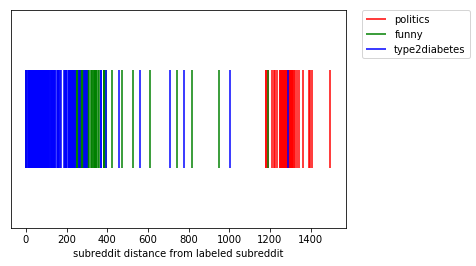

In [19]:
plt.eventplot(distframe['politics'], color='r', label='politics')
plt.eventplot(distframe['funny'], color='g', label='funny')
plt.eventplot(distframe['type2diabetes'], color='b',label='type2diabetes')
plt.yticks([])
plt.xlabel('subreddit distance from labeled subreddit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This second plot tells us another important story, although it looks almost entirely blue, this is because the blue overlays the other two subreddits. What this plot tells us is that these subreddits have similar user distributions, as the distance between these subreddits and all others is pretty similar. This makes some sense because all these subreddits are computer related. Competitive overwatch is a video game, lisk is a programming language, and stevenuniverse is a cartoon associated with adult nerds.

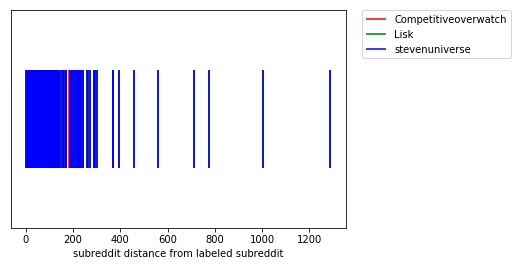

In [20]:
plt.eventplot(distframe['Competitiveoverwatch'], color='r', label='Competitiveoverwatch')
plt.eventplot(distframe['Lisk'], color='g', label='Lisk')
plt.eventplot(distframe['stevenuniverse'], color='b',label='stevenuniverse')
plt.yticks([])
plt.xlabel('subreddit distance from labeled subreddit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Finally, we wanted to look at these distances in a more useful way. Like the clustering distances, we organize each row and get the closest 100 subreddits to each other subreddits, and furthest 100 subreddits from each subreddit.

In [21]:
sub_mins = pd.DataFrame()
sub_maxs = pd.DataFrame()
for index,row in distframe.iterrows():
    sub_mins[index] = list(distframe.columns[row.argsort()][0:100])
    sub_maxs[index] = list(distframe.columns[row.argsort()][-99:])
    
sub_mins=sub_mins.transpose()
sub_maxs=sub_maxs.transpose()

In [22]:
sub_mins

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cocktails,cocktails,Lisk,stevenuniverse,politics,Competitiveoverwatch,type2diabetes,funny,lifehacks,boltedontits,QuakeChampions,...,darkestdungeon,cade,vidme,eu4,CongratsLikeImFive,ketorecipes,worldbuilding,SugarPine7,CasualUK,Edinburgh
AskReddit,type2diabetes,AskReddit,stevenuniverse,Lisk,Competitiveoverwatch,thighhighs,keto,tipofmyjoystick,asmr,wikipedia,...,Diablo3Wizards,Zoomies,worldbuilding,ghostbusters,Schoolhouse,Lottery,HelpMeFind,Bellingham,AskNYC,comicbooks
hearthstone,hearthstone,stevenuniverse,Lisk,asoiaf,atheism,prochoice,Hoocoodanode,type2diabetes,kratom,PropagandaPosters,...,CrappyDesign,classiccars,PenmanshipPorn,unpopularopinion,Honolulu,humor,awwwtf,CollegeBasketball,eu4,darkestdungeon
dontdeadopeninside,dontdeadopeninside,Lisk,stevenuniverse,Competitiveoverwatch,type2diabetes,confessions,powerwashingporn,Charleston,ArtisanVideos,Tgirls,...,subnautica,awesome,BirdsBeingDicks,nuc,Animesuggest,glutenfree,asklaw,NameThatSong,SolarCity,vegan
funny,Lisk,stevenuniverse,Competitiveoverwatch,type2diabetes,stunfisk,news,NintendoSwitch,PerfectTiming,funny,PublicFreakout,...,britishproblems,photoshopbattles,Braincels,ForeverAlone,CyclePDX,indieheads,classiccars,AdventureBuilders,synology,Whatisthis
TWWPRDT,TWWPRDT,Lisk,stevenuniverse,Competitiveoverwatch,type2diabetes,funny,stunfisk,Overwatch,pics,Damnthatsinteresting,...,bostonceltics,farcry,Vaping,nintendo,GooglePixel,recumbent,totallynotrobots,Michigan,RoomPorn,Cimmeria
vexillology,vexillology,Doom,DebateAnAtheist,comics,BirdsBeingDicks,Digibro,Lisk,trailerparkboys,stevenuniverse,awesome,...,BuyItForLife,eu4,cade,france,RimWorld,tasker,blues,worldbuilding,INEEEEDIT,CasualUK
therewasanattempt,therewasanattempt,Lisk,stevenuniverse,type2diabetes,Competitiveoverwatch,gamedev,gtaonline,CinemaSins,boltedontits,newsokur,...,Ohlympics,Gloomhaven,Lottery,Diablo3Wizards,friendsafari,humor,MsBreezy,shorthairedhotties,LegalAdviceUK,france
IntoTheBreach,IntoTheBreach,Lisk,stevenuniverse,type2diabetes,Competitiveoverwatch,NotHowGirlsWork,Weakpots,brasil,lastmansitting,instant_regret,...,FilmIndustryLA,shorthairedhotties,Jaguars,MostBeautiful,jobs,Animesuggest,BreakUps,Israel,RoomPorn,SexyFrex
news,news,Lisk,stevenuniverse,Competitiveoverwatch,type2diabetes,bicycling,NintendoSwitch,PokemonGoDenver,ForeverAlone,tipofmytongue,...,witcher,corgibutts,Innokin,farcry,prettyaltgirls,Strava,worldbuilding,kotor,photography,Whatisthis


In [23]:
sub_maxs.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
cocktails,digitaltabletop,TheFacebookDelusion,MarkMyWords,linux_devices,ForeverAlone,WouldYouFuckMyWife,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,...,Anticonsumption,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT
AskReddit,Vaporwave,motorcitykitties,tall,TheFacebookDelusion,MarkMyWords,linux_devices,WouldYouFuckMyWife,witbox,digitaltabletop,Denmark,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
hearthstone,TheFacebookDelusion,motorcitykitties,ForeverAlone,linux_devices,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,oddlysatisfying,Denmark,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
dontdeadopeninside,TheFacebookDelusion,motorcitykitties,MarkMyWords,linux_devices,Denmark,WouldYouFuckMyWife,ForeverAlone,AsheronsCall,SWlegion,TheBullWins,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
funny,interiordecorating,freedommobile,psychology,Breadit,opieandanthony,AskKrepo,DragonAgeCoOp,Whatcouldgowrong,4U9525,sanfrancisco,...,ImaginaryBehemoths,HomeNetworking,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics


# Where the fun begins

    This is where the fun begins, because now we can start looking up specific subreddits, and seeing the kinds of correlations that come up. For example:

In [26]:
sub_mins.loc['The_Donald']

0               The_Donald
1                     Lisk
2           stevenuniverse
3     Competitiveoverwatch
4            type2diabetes
5          digitaltabletop
6           opieandanthony
7              ProductPorn
8            IRLEasterEggs
9                   twinks
10                freefolk
11           linux_devices
12                    okko
13            microgrowery
14                 bayarea
15           nonononoyesno
16      AustralianShepherd
17      WhitePeopleTwitter
18            gratefuldead
19           100DaysofKeto
20                  Guitar
21        ImaginaryDragons
22         MarchForScience
23             exchristian
24             classiccars
25                   screw
26        ImagesOfThe2010s
27                EverWing
28                 Bowling
29                  me_irl
              ...         
70                niceguys
71                   vidme
72             nottheonion
73                 diablo3
74               indonesia
75                     TNA
7

# Statistical Analysis

To perform statistical analysis on our data, we read in small data set. Both .csv files contain the same users. One file contains a user's comment frequency data, and the other contains that same user's submission frequency data.

In [ ]:
donaldc = pd.read_csv('donaldCFreq.csv')
donalds = pd.read_csv('donaldSFreq.csv')

print("DonaldCFreq:")
print(donaldc)
print("donaldSFreq:")
print(donalds)

In [ ]:
#dataframe for donaldc
donaldc["total_comments"] = donaldc.sum(axis = 1)
donaldc["total_comments"]

In [ ]:
#dataframe for donalds
donalds["total_submissions"] = donalds.sum(axis = 1)
donalds["total_submissions"]

In [ ]:
donaldCombined = pd.DataFrame()
donaldCombined["#Comments"] = donaldc["total_comments"]
donaldCombined["#Submissions"] = donalds["total_submissions"]
donaldCombined = donaldCombined.dropna()
donaldCombined

Delete submissions > 800:

In [ ]:
donaldCombined = donaldCombined[donaldCombined["#Submissions"] < 800] 
donaldCombined

Now, calculate Z scores to normalize the data, so we can perform statistical analysis.

In [ ]:
import scipy.stats

donaldCombined['#Comments_Z'] = scipy.stats.zscore(donaldCombined['#Comments'])
donaldCombined['#Submissions_Z'] = scipy.stats.zscore(donaldCombined['#Submissions'])

sub_mins

In [ ]:
sub_maxs.head()

To check specific subreddits:

In [ ]:
#enter the subreddit name that you would like to check ['here']
sub_mins.loc['ramen']

# Statistical Analysis

To perform statistical analysis on our data, we read in small data set. Both .csv files contain the same users. One file contains a user's comment frequency data, and the other contains that same user's submission frequency data.

In [ ]:
donaldc = pd.read_csv('donaldCFreq.csv')
donalds = pd.read_csv('donaldSFreq.csv')

print("DonaldCFreq:")
print(donaldc)
print("donaldSFreq:")
print(donalds)

In [ ]:
#dataframe for donaldc
donaldc["total_comments"] = donaldc.sum(axis = 1)
donaldc["total_comments"]

In [ ]:
#dataframe for donalds
donalds["total_submissions"] = donalds.sum(axis = 1)
donalds["total_submissions"]

In [ ]:
donaldCombined = pd.DataFrame()
donaldCombined["#Comments"] = donaldc["total_comments"]
donaldCombined["#Submissions"] = donalds["total_submissions"]
donaldCombined = donaldCombined.dropna()
donaldCombined

Delete submissions > 800:

In [ ]:
donaldCombined = donaldCombined[donaldCombined["#Submissions"] < 800] 
donaldCombined

Now, calculate Z scores to normalize the data, so we can perform statistical analysis.

In [ ]:
import scipy.stats

donaldCombined['#Comments_Z'] = scipy.stats.zscore(donaldCombined['#Comments'])
donaldCombined['#Submissions_Z'] = scipy.stats.zscore(donaldCombined['#Submissions'])

sub_mins

In [51]:
sub_maxs.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
cocktails,MarkMyWords,linux_devices,ForeverAlone,WouldYouFuckMyWife,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
AskReddit,Vaporwave,motorcitykitties,tall,TheFacebookDelusion,MarkMyWords,linux_devices,WouldYouFuckMyWife,witbox,digitaltabletop,Denmark,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
hearthstone,TheFacebookDelusion,motorcitykitties,ForeverAlone,linux_devices,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,oddlysatisfying,Denmark,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
dontdeadopeninside,TheFacebookDelusion,motorcitykitties,MarkMyWords,linux_devices,Denmark,WouldYouFuckMyWife,ForeverAlone,AsheronsCall,SWlegion,TheBullWins,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
funny,interiordecorating,freedommobile,psychology,Breadit,opieandanthony,AskKrepo,DragonAgeCoOp,Whatcouldgowrong,4U9525,sanfrancisco,...,ImaginaryBehemoths,HomeNetworking,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics


To check specific subreddits:

In [45]:
#enter the subreddit name that you would like to check ['here']
sub_mins.loc['The_Donald']

0               The_Donald
1                     Lisk
2           stevenuniverse
3     Competitiveoverwatch
4            type2diabetes
5          digitaltabletop
6           opieandanthony
7              ProductPorn
8            IRLEasterEggs
9                   twinks
10                freefolk
11           linux_devices
12                    okko
13            microgrowery
14                 bayarea
15           nonononoyesno
16      AustralianShepherd
17      WhitePeopleTwitter
18            gratefuldead
19           100DaysofKeto
20                  Guitar
21        ImaginaryDragons
22         MarchForScience
23             exchristian
24             classiccars
25                   screw
26        ImagesOfThe2010s
27                EverWing
28                 Bowling
29                  me_irl
              ...         
70                niceguys
71                   vidme
72             nottheonion
73                 diablo3
74               indonesia
75                     TNA
7

# Statistical Analysis

To perform statistical analysis on our data, we read in small data set. Both .csv files contain the same users. One file contains a user's comment frequency data, and the other contains that same user's submission frequency data.

In [22]:
donaldc = pd.read_csv('donaldCFreq.csv')
donalds = pd.read_csv('donaldSFreq.csv')

print("DonaldCFreq:")
print(donaldc)
print("donaldSFreq:")
print(donalds)

DonaldCFreq:
               Unnamed: 0  thedonald  todayilearned  news  bestoflegaladvice  \
0                 A-A-V-E        0.0            0.0   0.0                0.0   
1              Adelleda25        0.0            0.0   0.0                0.0   
2            ArrantPariah        0.0            0.0   0.0                0.0   
3           BarzTheOrange        0.0            0.0   1.0                0.0   
4          CallTheKiteman        0.0            0.0   7.0                0.0   
5          CannotStopEver        0.0            0.0   0.0                0.0   
6    CommonMisspellingBot        0.0            0.0   1.0                0.0   
7          Common_Fanfare        0.0            0.0   0.0                0.0   
8               Dieseldad        0.0            0.0   0.0                0.0   
9         Emmenthalreddit        0.0            0.0   0.0                0.0   
10        FixBayonetsLads        0.0            0.0   0.0                0.0   
11         GThaDeplorable  

In [23]:
#dataframe for donaldc
donaldc["total_comments"] = donaldc.sum(axis = 1)
donaldc["total_comments"]

0       736.0
1       177.0
2       998.0
3        66.0
4       998.0
5      1000.0
6      1000.0
7       254.0
8       755.0
9       273.0
10      639.0
11       23.0
12      999.0
13       17.0
14       17.0
15     1000.0
16        5.0
17      419.0
18      999.0
19     1000.0
20       28.0
21        1.0
22      130.0
23      211.0
24      563.0
25       40.0
26       41.0
27      440.0
28       74.0
29       23.0
        ...  
75       27.0
76     1000.0
77      358.0
78     1000.0
79        2.0
80       27.0
81     1000.0
82       16.0
83        1.0
84        7.0
85     1000.0
86      100.0
87       81.0
88      999.0
89      603.0
90     1000.0
91      992.0
92        4.0
93        4.0
94       32.0
95       37.0
96     1000.0
97      294.0
98      791.0
99      999.0
100     426.0
101     996.0
102    1000.0
103     410.0
104     755.0
Name: total_comments, Length: 105, dtype: float64

In [24]:
#dataframe for donalds
donalds["total_submissions"] = donalds.sum(axis = 1)
donalds["total_submissions"]

0       61.0
1        8.0
2     1000.0
3        7.0
4       25.0
5      263.0
6        1.0
7       18.0
8       23.0
9        1.0
10     285.0
11     157.0
12       6.0
13      37.0
14       2.0
15      12.0
16      13.0
17     157.0
18       2.0
19      31.0
20      42.0
21     167.0
22      52.0
23      27.0
24      32.0
25       3.0
26       4.0
27      28.0
28       7.0
29     285.0
       ...  
59      85.0
60      33.0
61      51.0
62      15.0
63     258.0
64       4.0
65      22.0
66      35.0
67     266.0
68       4.0
69      11.0
70     216.0
71       1.0
72      60.0
73       7.0
74       4.0
75     338.0
76      10.0
77     116.0
78     100.0
79       1.0
80     240.0
81      85.0
82     273.0
83      23.0
84       6.0
85      56.0
86     163.0
87      25.0
88      11.0
Name: total_submissions, Length: 89, dtype: float64

In [25]:
donaldCombined = pd.DataFrame()
donaldCombined["#Comments"] = donaldc["total_comments"]
donaldCombined["#Submissions"] = donalds["total_submissions"]
donaldCombined = donaldCombined.dropna()
donaldCombined

,#Comments,#Submissions
0,736.0,61.0
1,177.0,8.0
2,998.0,1000.0
3,66.0,7.0
4,998.0,25.0
5,1000.0,263.0
6,1000.0,1.0
7,254.0,18.0
8,755.0,23.0
9,273.0,1.0


Delete submissions > 800:

In [26]:
donaldCombined = donaldCombined[donaldCombined["#Submissions"] < 800] 
donaldCombined

,#Comments,#Submissions
0,736.0,61.0
1,177.0,8.0
3,66.0,7.0
4,998.0,25.0
5,1000.0,263.0
6,1000.0,1.0
7,254.0,18.0
8,755.0,23.0
9,273.0,1.0
10,639.0,285.0


Now, calculate Z scores to normalize the data, so we can perform statistical analysis.

In [27]:
import scipy.stats

donaldCombined['#Comments_Z'] = scipy.stats.zscore(donaldCombined['#Comments'])
donaldCombined['#Submissions_Z'] = scipy.stats.zscore(donaldCombined['#Submissions'])

/Users/laurahimelman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/laurahimelman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Scatter plot of Z scores:

In [ ]:
#scatter plot of Z scores
plt.scatter(donaldCombined['#Comments_Z'], donaldCombined['#Submissions_Z'])
plt.show

Run Pearson Correlation Coefficient to find correlation between two columns:

In [ ]:
donaldCombined['#Comments_Z'].corr(donaldCombined['#Submissions_Z'])

The correlation coefficient is about -0.25, making it somewhat anti-correlated. While this is not a very strong anti-correlation, it might still be assumed that users who comment a lot do not post submissions.